In [1]:
import os, sys, time, numpy, torch, matplotlib.pyplot

sys.path.append(os.path.abspath(os.path.join('..')))  # Allow repository modules to be imported

# Noisy XOR data

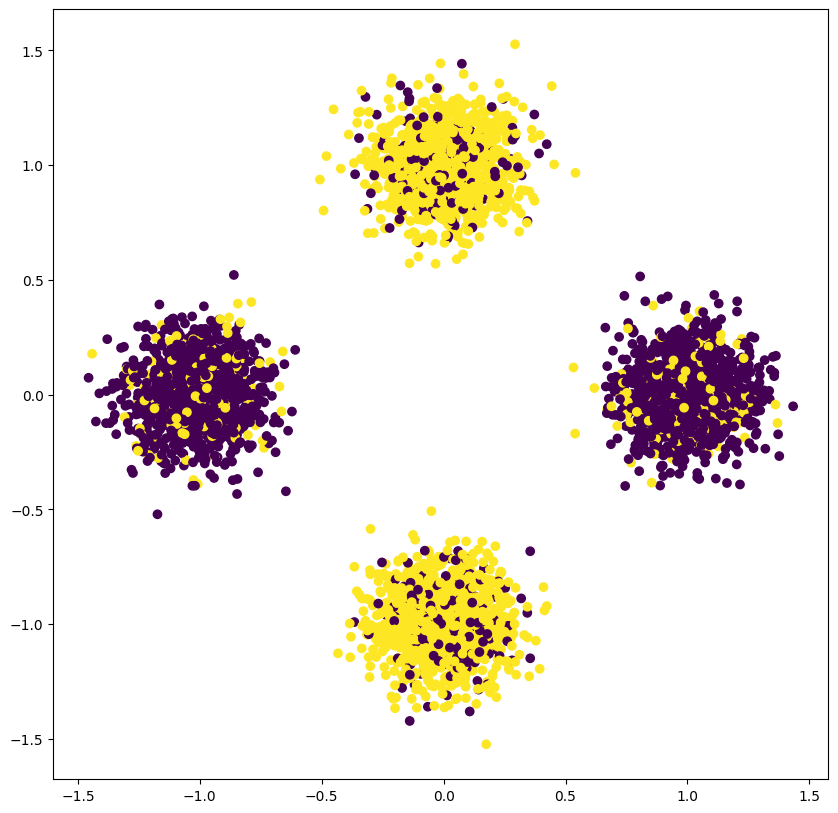

In [2]:
from settings.noisy_xor import get_dataloader

data_setting = {
    'seed': 1234,
    'input_dimension': 2, 
    'sample_size': 5000,  
    'batch_size': 5000, 
    'noise_rate': 0.15,
    'within_cluster_variance': 1. / 50.
}

data, rotation_matrix = get_dataloader(**data_setting)
_, (inputs, labels) = next(enumerate(data))

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
inputs_ = numpy.matmul(inputs.detach().cpu().numpy(), rotation_matrix.transpose())
ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels)

In [3]:
model_setting = {
    'epochs': 10000,
    'learning_rate': 0.05,
    'batch_size': data_setting['sample_size'],
    'hidden_units': 2,
    'bias': False,
    'initialization_variance': 1. / data_setting['input_dimension'] ** 1.2
}

class TwoLayerNeuralNet(torch.nn.Module):

    def __init__(self, input_dimension:int, hidden_units:int, initialization_variance:float=1., bias:bool=True, *args, **kwargs):
        super(TwoLayerNeuralNet, self).__init__()
        self.device = 'cpu'
        self.hidden_units = hidden_units
        self.input_dimension = input_dimension
        if hidden_units % 2 == 1:
            hidden_units -= 1
            print(f'Only even number of hidden units allowed. Switching to hidden units = {hidden_units}') 

        self.input_layer = torch.nn.Linear(input_dimension, hidden_units, bias=bias)
        torch.nn.init.normal_(self.input_layer.weight, std=initialization_variance ** 0.5)
        self.activation = torch.nn.ReLU()
        output_layer_weights = [1. / hidden_units ** 0.5] * (hidden_units // 2) + [-1. / hidden_units ** 0.5] * (hidden_units // 2)
        self.output_layer_weights = torch.tensor(output_layer_weights)

        self.dummy_variable1 = torch.zeros(hidden_units, hidden_units, requires_grad=True)
        self.dummy_variable1.retain_grad()

        self.dummy_variable2 = torch.zeros(input_dimension, input_dimension, requires_grad=True)
        self.dummy_variable2.retain_grad()
        
    def forward(self, x):
        #dummy_term2 = (
        #    x.reshape(-1, self.input_dimension, 1).bmm(x.mm(self.dummy_variable2).reshape(-1, 1, self.input_dimension))
        #)
        self.pre_activations = self.input_layer(x).requires_grad_() #+ dummy_term2
        self.pre_activations.retain_grad()
        self.activations = self.activation(self.pre_activations).requires_grad_()
        self.activations.retain_grad()
        #dummy_term1 = (
        #    self.activations.unsqueeze(1).bmm(self.activations.mm(self.dummy_variable1)
        #        .reshape(-1, self.hidden_units, 1)).reshape(-1)
        #)
        output = torch.matmul(self.activations, self.output_layer_weights) #+ dummy_term1
        return output.unsqueeze(1)

    def to(self, device):
        super().to(device)
        self.output_layer_weights = self.output_layer_weights.to(device)
        self.dummy_variable1 = self.dummy_variable1.to(device)
        self.dummy_variable1.retain_grad()
        self.dummy_variable2 = self.dummy_variable2.to(device)
        self.dummy_variable2.retain_grad()
        self.device = device
        return self


In [4]:
import ipycanvas

training_canvas, gradients_norms_canvas, input_domain_canvas = ipycanvas.Canvas(), ipycanvas.Canvas(), ipycanvas.Canvas()
training_canvas.width = training_canvas.height = 800
gradients_norms_canvas.width = 1200; gradients_norms_canvas.height = 600
input_domain_canvas.width = input_domain_canvas.height = 800
training_canvas.font = gradients_norms_canvas.font = input_domain_canvas.font = "30px arial"
args = ('Results will appear as processed', training_canvas.width / 4, training_canvas.height / 3)
training_canvas.fill_text(*args); gradients_norms_canvas.fill_text(*args); input_domain_canvas.fill_text(*args)

In [5]:
training_canvas

Canvas(height=800, width=800)

In [6]:
gradients_norms_canvas

Canvas(height=600, width=1200)

In [7]:
input_domain_canvas

Canvas(height=800, width=800)

In [8]:
from utils.optimization import initialize, train, test, Accuracy
from plots import plot_experiment, plot_gradients_norms, plot_samples_and_model_activation_and_neurons_hyperplanes

plots_epochs_interval = 1000

experiment = {
    **data_setting,
    **model_setting,
    'train': 'Accuracy',
    'test': 'Accuracy',
    'train_time': 'seconds',
    'models_runs': []
}

device = initialize(experiment['seed'])
train_data, rotation_matrix = get_dataloader(**experiment) 
test_data = get_dataloader(**experiment, rotation_matrix=rotation_matrix)
model = TwoLayerNeuralNet(**experiment).to(device)
train_loss, test_loss = torch.nn.BCEWithLogitsLoss(), Accuracy
optimizer = torch.optim.SGD(model.parameters(), lr=experiment['learning_rate'])
run = {
    'distinction': '1',
    'train': [test(train_data, model, test_loss, device)],
    'train_time': [0],
    'test': [test(test_data, model, test_loss, device, verbose=False)]
}
experiment['models_runs'].append(run)

def gradients_summary(model, *args, epoch_frequency=1):
    epoch = len(run.get('train', []))
    if epoch == 0 or epoch % epoch_frequency != 0: return

    sample_size = experiment['sample_size']
    pre_activations_gradients_average_norm = model.pre_activations.grad.mean(dim=0).norm().item() * sample_size
    run['pre_activations_gradients_average_norm'] = \
        run.get('pre_activations_gradients_average_norm', []) + [pre_activations_gradients_average_norm]
    
    activations_gradients_average_norm = model.activations.grad.mean(dim=0).norm().item() * sample_size
    run['activations_gradients_average_norm'] = \
        run.get('activations_gradients_average_norm', []) + [activations_gradients_average_norm]

    pre_activations_average_gradient_norm = model.pre_activations.grad.norm(dim=1).mean().item() * sample_size
    run['pre_activations_average_gradient_norm'] = \
        run.get('pre_activations_average_gradient_norm', []) + [pre_activations_average_gradient_norm]
    
    activations_average_gradient_norm = model.activations.grad.norm(dim=1).mean().item() * sample_size
    run['activations_average_gradient_norm'] = \
        run.get('activations_average_gradient_norm', []) + [activations_average_gradient_norm]

plot_samples_and_model_activation_and_neurons_hyperplanes(dataloader=train_data, model=model, rotation_matrix=rotation_matrix, 
                                                          **experiment, canvas=input_domain_canvas)

for epoch in range(1, experiment['epochs'] + 1):
    start_time = time.time()
    train(train_data, model, train_loss, optimizer, device, verbose=False, callback=gradients_summary)
    end_time = time.time()
    train_time = run['train_time'][-1] + end_time - start_time
    train_loss_value = test(train_data, model, test_loss, device, verbose=False)
    test_loss_value = test(test_data, model, test_loss, device, verbose=False)
    run['train'].append(train_loss_value)
    run['train_time'].append(train_time)
    run['test'].append(test_loss_value)
    if epoch % plots_epochs_interval == 0 or epoch == experiment['epochs']:
        plot_experiment(experiment, training_canvas)
        plot_gradients_norms(run, canvas=gradients_norms_canvas)
        plot_samples_and_model_activation_and_neurons_hyperplanes(
            dataloader=train_data, model=model, rotation_matrix=rotation_matrix, **experiment, 
            canvas=input_domain_canvas)


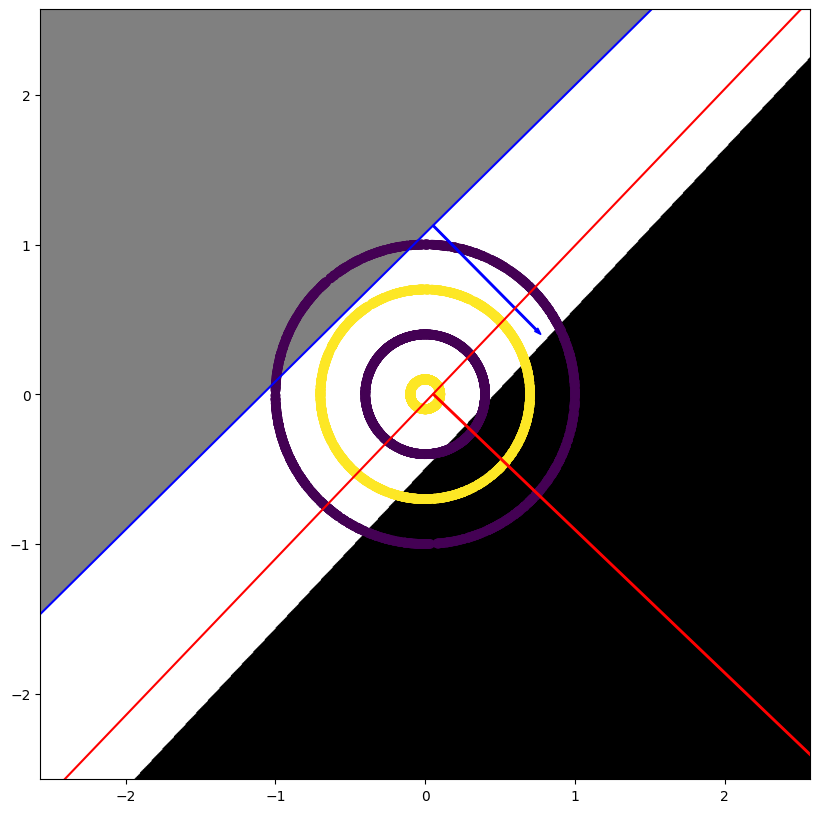

In [ ]:
plot_samples_and_model_activation_and_neurons_hyperplanes(dataloader=train_data, model=model, rotation_matrix=rotation_matrix, **experiment)

In [ ]:
_, (inputs, labels) = next(enumerate(train_data))

In [ ]:
sample.shape

NameError: name 'sample' is not defined

In [ ]:
input_dimension = data_setting['input_dimension']
extended_sample = numpy.concatenate([sample[:2], numpy.repeat(0., input_dimension - 2)], axis=0)
extended_sample.shape

In [ ]:
model(torch.tensor([extended_sample], dtype=torch.float32).to(model.device))

In [ ]:
sample = numpy.matmul(inputs[0], rotation_matrix.transpose())

mean = [sample[0].item(), sample[1].item()]

In [ ]:
plot_samples_and_model_activation_and_neurons(dataloader=train_data, model=model, rotation_matrix=rotation_matrix, **experiment, mean=mean, scale=0.01)